In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
tows_data = pd.read_csv('tows.csv', parse_dates=['Tow Date'])
tows_data = tows_data.dropna(subset=['Tow Date'])

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


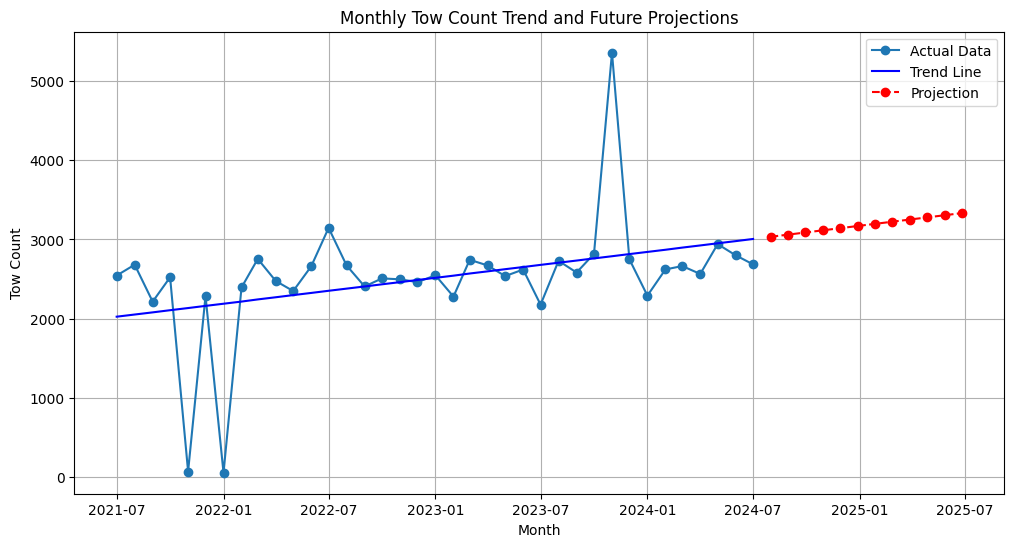

   Month Start  Predicted Tow Count
0   2024-07-31          3033.481982
1   2024-08-30          3060.764817
2   2024-09-29          3088.047653
3   2024-10-29          3115.330488
4   2024-11-28          3142.613324
5   2024-12-28          3169.896159
6   2025-01-27          3197.178995
7   2025-02-26          3224.461830
8   2025-03-28          3251.744666
9   2025-04-27          3279.027501
10  2025-05-27          3306.310337
11  2025-06-26          3333.593172


In [4]:

# Extract year and month for grouping
tows_data['YearMonth'] = tows_data['Tow Date'].dt.to_period('M')

# Aggregate tow counts by month, skipping missing months
monthly_tows = tows_data.groupby('YearMonth').size().reset_index(name='Tow Count')

# Convert YearMonth period to datetime for analysis
monthly_tows['Month Start'] = monthly_tows['YearMonth'].dt.start_time
monthly_tows['Months Since Start'] = (monthly_tows['Month Start'] - monthly_tows['Month Start'].min()).dt.days // 30

# Prepare data for regression
X = monthly_tows[['Months Since Start']]
y = monthly_tows['Tow Count']

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict for future months
future_months = np.arange(monthly_tows['Months Since Start'].max() + 1,
                          monthly_tows['Months Since Start'].max() + 13).reshape(-1, 1)
future_month_dates = [monthly_tows['Month Start'].max() + pd.Timedelta(days=30 * i) for i in range(1, 13)]
future_predictions = model.predict(future_months)

# Plot the data and projections (Line Graph)
plt.figure(figsize=(12, 6))
plt.plot(monthly_tows['Month Start'], monthly_tows['Tow Count'], marker='o', label='Actual Data')
plt.plot(monthly_tows['Month Start'], model.predict(X), color='blue', label='Trend Line')
plt.plot(future_month_dates, future_predictions, color='red', linestyle='--', marker='o', label='Projection')
plt.xlabel('Month')
plt.ylabel('Tow Count')
plt.title('Monthly Tow Count Trend and Future Projections')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame for future projections
future_month_df = pd.DataFrame({
    'Month Start': future_month_dates,
    'Predicted Tow Count': future_predictions
})

# Display the future projections
print(future_month_df)


In [15]:

fig = go.Figure()

# Add Actual Data
fig.add_trace(go.Scatter(
    x=monthly_tows['Month Start'],
    y=monthly_tows['Tow Count'],
    mode='markers+lines',
    name='Actual Data',
    marker=dict(color='#4c78a8'),
    line=dict(color='#4c78a8')
))

# Add Trend Line
fig.add_trace(go.Scatter(
    x=monthly_tows['Month Start'],
    y=model.predict(X),
    mode='lines',
    name='Trend Line',
    line=dict(color='#54a24b', dash='solid')
))

# Add Projections
fig.add_trace(go.Scatter(
    x=future_month_dates,
    y=future_predictions,
    mode='markers+lines',
    name='Projection',
    marker=dict(color='#e45756'),
    line=dict(color='#e45756', dash='dot')
))

# Customize layout
fig.update_layout(
    title='Monthly Tow Count Trend and Future Projections',
    xaxis_title='Month',
    yaxis_title='Tow Count',
    legend_title='Legend',
    template='plotly_white'
)

# Save and display the graph
fig.write_html("tow_projections_interactive.html")
fig.show()


The plot with table..

In [13]:

# Create a Plotly graph
graph_fig = go.Figure()

# Add Actual Data
graph_fig.add_trace(go.Scatter(
    x=monthly_tows['Month Start'],
    y=monthly_tows['Tow Count'],
    mode='markers+lines',
    name='Actual Data',
    marker=dict(color='#4c78a8'),
    line=dict(color='#4c78a8')
))

# Add Smoothed Trend Line
graph_fig.add_trace(go.Scatter(
    x=pd.date_range(start=monthly_tows['Month Start'].min(),
                    end=monthly_tows['Month Start'].max(),
                    periods=500),
    y=model.predict(X),
    mode='lines',
    name='Trend Line',
    line=dict(color='#54a24b', dash='solid')
))

# Add Projections
graph_fig.add_trace(go.Scatter(
    x=future_month_dates,
    y=future_predictions,
    mode='markers+lines',
    name='Projection',
    marker=dict(color='#e45756', symbol='circle'),
    line=dict(color='#e45756', dash='dot')
))

# Layout customization for graph
graph_fig.update_layout(
    title='Monthly Tow Count Trend and Future Projections',
    xaxis_title='Month',
    yaxis_title='Tow Count',
    legend_title='Legend',
    template='plotly_white',
    hovermode='x unified',
    font=dict(size=14)
)

# Save the graph alone as HTML
graph_only_path = 'tow_projections_graph.html'
pio.write_html(graph_fig, file=graph_only_path, auto_open=False)

# Create the table for future predictions
table_fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Month Start</b>", "<b>Predicted Tow Count</b>"],
        fill_color='grey',
        align='left',
        font=dict(size=14)
    ),
    cells=dict(
        values=[future_month_df['Month Start'].dt.strftime('%Y-%m-%d'), future_month_df['Predicted Tow Count'].round(2)],
        fill_color='lavender',
        align='left',
        font=dict(size=12)
    )
)])

fig.show()

# Save graph and table together as HTML
combined_html_path = 'tow_projections_with_table.html'
with open(combined_html_path, 'w') as f:
    f.write('<h1>Monthly Tow Count Trend and Future Projections</h1>')
    f.write(graph_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write('<h2>Future Predictions Table</h2>')
    f.write(table_fig.to_html(full_html=False, include_plotlyjs=False))

# Print save locations
print(f"Graph and Table HTML saved at: {combined_html_path}")


Graph and Table HTML saved at: tow_projections_with_table.html


In [9]:
tows = pd.read_csv('tows.csv')
reasons = tows.groupby('Reason for tow').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
print(reasons)

49882/len(tows)

                           Reason for tow  Count
9                    No Overnight Parking  49882
14                   Unauthorized Parking  22934
12                       Private Property   8732
4   Expired Permit, Tags, or Registration   4870
1                      Blocking Fire Lane   3648
0                       Abandoned Vehicle   1523
2                        Disabled Vehicle    213
10                              No Permit    114
7                          Invalid Permit     80
6                           Handicap Spot     79
3                          Double Parking     36
16              Visitor Parking Violation     32
8                      Management request     20
15                                Unknown     18
11                         Parking Unpaid      6
13                                 Stolen      3
5                             Fake permit      1


0.5360255321892563